<a href="https://colab.research.google.com/github/GuangyuNie/MAE_598_Optimization/blob/master/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

logger = logging.getLogger(__name__)

We modify the following setting to make the problem more realistic: 
1. Instead of having only one set of nozzle controlling linear motion, we assume there is another set of rocket nozzle that can rotate the rocket cw/ccw with fixed angular accerlation which can be turned on or off.
2. The state space of the rocket is now 6D, $S = \{x, \dot{x}, y, \dot{y}, \theta, \dot{\theta}\}$, where $\theta$ is the angle between the rocket and the y axis. The action space A of the rocket is 3D, $A = \{q_l, q_\omega, d_\omega\}$, where $q_l$ indicate if the linear thrust is on or off, $q_\omega$ indicate if the angular thrust is on or off. $q_l, q_\omega \in\{0,1\}$. $d_\omega \in \{-1, 1\}$ indicate whether the rocket is rotating cw or ccw. 


The optimization problem can be formulated as:

\begin{equation}
\begin{aligned}
&L = \min_S |||\lambda_1^TS(T)||^2 + \sum_i^{T-1} ||\lambda_2^TS(t)||^2\\
\text{s.t.} \quad & d(t+1) = d(t) + v(t)\Delta t \\
& v(t+1) = v(t) + a(t)\Delta t \\
& \theta(t+1) = \theta(t) + \omega(t)\Delta t \\
& \omega(t+1) = \omega(t) + \dot{\omega}(t)\Delta t \\
& a(t)= f_\theta(S(t)), ∀t=1, ..., T-1 \\
\end{aligned}
\end{equation}

Where $\lambda_1$ and $\lambda_2$ are set trivially and are not calculated in this project

In [2]:
# environment parameters

FRAME_TIME = 1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
ROTATION_ACCEL = 20 / 180 * math.pi  # rotation constant

In [3]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action[0]: linear thrust on or off
        action[1]: angular thrust on or off
        action[2]: angular thrust cw or ccw
        state[0] = x
        state[1] = x_dot
        state[2] = y
        state[3] = y_dot
        state[4] = theta
        state[5] = theta_dot
        """
        sigmoid = t.nn.Sigmoid()
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., 0., 0, GRAVITY_ACCEL * FRAME_TIME, 0, 0])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        # delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([math.cos(state[2]+action[1]), math.sin(state[2]+action[1])]) * action[0]
        delta_x = BOOST_ACCEL * FRAME_TIME * t.sin(state[4]) * action[0] * t.tensor([0,1,0,0,0,0])
        delta_y = (BOOST_ACCEL * FRAME_TIME * t.cos(state[4]) * action[0] - delta_state_gravity) * t.tensor([0,0,0,1,0,0])
        delta_w = ROTATION_ACCEL * FRAME_TIME * action[1] * (2*action[2]-1)  * t.tensor([0,0,0,0,0,1])


        # Update velocity
        state = state + delta_x + delta_y + delta_w        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                    [0., 1., 0., 0., 0., 0.,],
                    [0., 0., 1., FRAME_TIME, 0., 0.],
                    [0., 0., 0., 1., 0., 0.,],
                    [0., 0, 0., 0., 1., FRAME_TIME],
                    [0., 0., 0., 0., 0., 1.,]])
        state = t.matmul(step_mat, state)
        # print(state)

        return state

In [4]:
# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.ReLU(0.2),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(0.2),
            # nn.Linear(dim_hidden, dim_hidden),
            # nn.LeakyReLU(0.2),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
            )

    def forward(self, state):
        action = self.network(state)
        #print(action)
        return action

In [5]:
# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        self.relu = t.nn.ReLU()

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        error=0
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
            error += self.error(state)
        return error+10*self.terminal_error(state)

    @staticmethod
    def initialize_state():
        state = [0.3, 0., 1., 0., 10/180*math.pi, 0]  
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
      return state[0] ** 2 + state[2] ** 2
    def terminal_error(self, state):
      return sum(state**2) + 10 * state[4]**2

In [6]:
# set up the optimizer
from matplotlib.animation import FuncAnimation, writers

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.005)
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        print('Note the loss will not converge to 0, because it\'s accumulated from t = 0,...,T')
        return self.simulation.state_trajectory


        # time_text.set_text(time_template % (0.1*i))

In [7]:
import matplotlib.patches as patches
patch = patches.Rectangle((0, 0), 0, 0, fc='y')

def animation_func(i):
    data_i = np.array([data[i].detach().numpy()])[0]
    w = 0.05
    h = 0.5
    patch.set_width(w)
    patch.set_height(h)
    patch.set_xy([data_i[0]-w/2, data_i[2]])
    patch.angle = (-np.rad2deg(data_i[4]))
    return patch

def init():
    ax.set_xlim(-2, 2)
    ax.set_ylim(0, 2)
    ax.set_xlabel('Rocket Horizontal Position(m)')
    ax.set_ylabel('Rocket Vertical Position(m)')
    ax.set_title('Rocket Landing Process')
    ax.add_patch(patch)
    return patch

In [8]:
# Now it's time to run the code!
t.manual_seed(123)
T = 20  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
data = o.train(60)  # solve the optimization problem





[1] loss: 1883.321
[2] loss: 1266.430
[3] loss: 983.084
[4] loss: 813.592
[5] loss: 693.283
[6] loss: 613.369
[7] loss: 544.902
[8] loss: 327.126
[9] loss: 312.509
[10] loss: 155.571
[11] loss: 138.528
[12] loss: 124.333
[13] loss: 111.601
[14] loss: 100.744
[15] loss: 92.481
[16] loss: 85.722
[17] loss: 79.868
[18] loss: 75.072
[19] loss: 71.506
[20] loss: 68.687
[21] loss: 66.079
[22] loss: 64.032
[23] loss: 62.423
[24] loss: 60.977
[25] loss: 59.425
[26] loss: 57.660
[27] loss: 54.681
[28] loss: 49.060
[29] loss: 44.010
[30] loss: 39.062
[31] loss: 34.137
[32] loss: 29.839
[33] loss: 27.155
[34] loss: 25.120
[35] loss: 23.362
[36] loss: 21.872
[37] loss: 20.640
[38] loss: 19.738
[39] loss: 19.043
[40] loss: 18.497
[41] loss: 18.065
[42] loss: 17.715
[43] loss: 17.425
[44] loss: 17.144
[45] loss: 16.850
[46] loss: 16.526
[47] loss: 16.334
[48] loss: 15.896
[49] loss: 15.309
[50] loss: 14.781
[51] loss: 14.544
[52] loss: 13.993
[53] loss: 13.478
[54] loss: 13.078
[55] loss: 12.745
[56

In [9]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.grid()

animation = FuncAnimation(fig, animation_func, frames=T, init_func = init, interval=500)

animation.save('rocket landing.gif', writer = "pillow", fps=10)
plt.show()

<IPython.core.display.Javascript object>



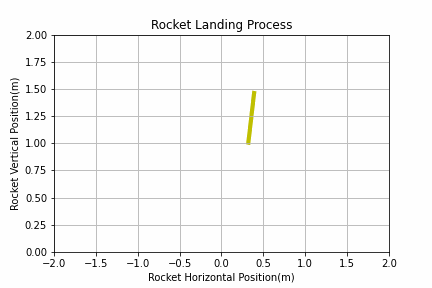